# Bootstrap


![Bootstrap](https://raw.githubusercontent.com/SchattenGenie/pic-storage/master/bootstrap.png)

![https://towardsdatascience.com/an-introduction-to-the-bootstrap-method-58bcb51b4d60](https://miro.medium.com/max/700/1*iH5w0MBdiOlxDOCX6nmqqw.png)

##### Оценки дисперсии функционалов

Пусть есть выборка $X = \{x_i\}_{i=1}^{n}$, некоторый функционал $T_n(X)$ и мы хотим оценить дисперсию $V_F(T_n)$. Не зная истинного распределения это можно сделать с помощью непараметрического или параметрического бутстрапа.

В непараметрическом бутстрапе оценка дисперсии делается следующим образом:

  1. Рэсемплим выборку с возвращением B раз: $X_1^*, X_2^*, X_B^* \sim X$
  2. Вычисляем $T_1^*, ..., T_B^*$
  3. $$V_F(T_n) \approx v_{boot} = \frac{1}{B - 1} \sum\limits_{b=1}^B \left(T_b^* - \bar{T}^*  \right)^2$$
  
  
Параметрический бутстрап отличается от непараметрического в первом шаге. Вместо сэмплирования из исходной выборки сэмплирование происходит из некоторого распределения, которое было найдено методом максимума правдоподобия по исходной выборке.

### Обоснование использование техники ресемплирования. 

Доказать эффективность и состоятельность оценки плотности вероятности функцией $\hat{F}(x) = \frac{1}{N} \sum\limits_i I[x > x_i]$.

$$E\left[ \hat{F}(x) \right] = F(x)$$


$$Var \left[ \hat{F}(x) \right] = \frac{F(x)(F(x) - 1)}{n}$$

# 0. Простой пример как работает бутстрап

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
%matplotlib inline

In [46]:
df = pd.read_csv('oldfaithful.csv')

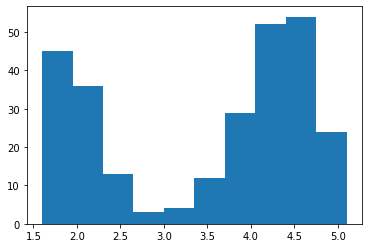

In [47]:
X = df['eruptions'].values
plt.hist(X);

In [48]:
N = len(X)
B = 5000
Xb = np.random.choice(X, (B, N), replace=True)

In [49]:
Xb.shape

(5000, 272)

#### Оценка дисперсии среднего

In [50]:
T = lambda x: np.mean(x, axis=1)

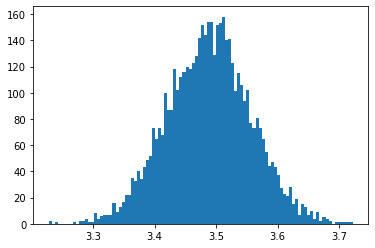

In [51]:
plt.hist(T(Xb), bins=100);

In [52]:
np.std(X) / np.sqrt(len(X))

0.06907846376450154

In [7]:
np.std(T(Xb))

0.06855843008096782

#### Оценка дисперсии медианы

In [58]:
T = lambda x: np.sqrt(((x - x.mean(axis=1, keepdims=True))**2).sum(axis=1) / (len(X)))

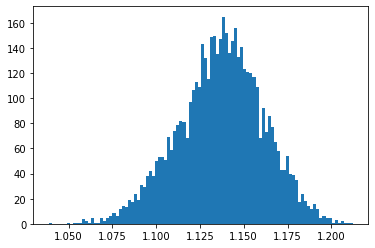

In [59]:
plt.hist(T(Xb), bins=100);

In [64]:
T(Xb).mean()

1.1370182722744533

In [65]:
np.sqrt(((X - X.mean())**2).sum() / (len(X) - 1))

1.141371251105208

In [62]:
T(Xb).mean() - np.sqrt(((X - X.mean())**2).sum() / (len(X)))

-0.0022529379513147596

In [63]:
np.sqrt(((X - X.mean())**2).sum() / (len(X))) - np.sqrt(((X - X.mean())**2).sum() / (len(X) - 1))

-0.002100040879440046

In [18]:
T = lambda x: np.median(x, axis=1)

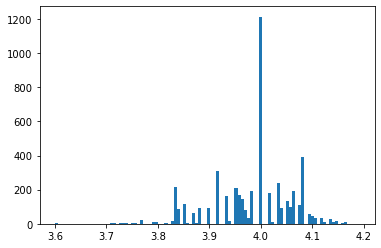

In [19]:
plt.hist(T(Xb), bins=100);

In [21]:
np.std(T(Xb))

0.07990589376610467

#### И даже оценка дисперсии дисперсии :)

In [44]:
X

array([[-208.60283333, -207.42283333, -206.69283333],
       [-207.42283333, -206.69283333, -207.72283333],
       [-206.69283333, -207.72283333, -209.20283333],
       ...,
       [  99.38716667,   97.26716667,  105.95716667],
       [  97.26716667,  105.95716667,  112.09716667],
       [ 105.95716667,  112.09716667,  111.53716667]])

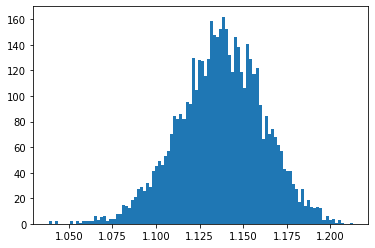

In [43]:
plt.hist(T(Xb), bins=100);

In [31]:
np.std(T(Xb))

15279.09429799516

# 1. Параметрический бутстрап временных рядов


Бутстреп временных рядов обычно делают в два шага:

  1. Обучают модель для предсказания временного ряда(авторегрессия, к примеру).
  $$y_t = \beta_0 + \beta_1 y_{t-1} + \beta_2 y_{t-2}$$
  2. Запоминают остатки(residuals) от истинных значений и предсказанных:
  $$\hat{\epsilon} = y_t - (\beta_0 + \beta_1 y_{t-1} + \beta_2 y_{t-2})$$
  3. Новые данные сэмплируют применяя обученную модель и добавляя к предсказанию случайно выбранное значение из residuals:
  $$\hat{y_t} = \beta_0 + \beta_1 \hat{y}_{t-1} + \beta_2 \hat{y}_{t-2} + (\epsilon \sim \hat{\epsilon}) $$
  
  
https://onlinecourses.science.psu.edu/stat501/node/358/

In [32]:
from sklearn import linear_model
import pandas as pd

clf = linear_model.LinearRegression(fit_intercept=False)

In [33]:
def make_regression_from_timeseries(X, n):
    """
    X: 1D-numpy массив временных данных
    n: количество сэмплов для предсказания
    return: X, Y = [x_{t-n}, x_{t-n+1}, ..., x_{t-1}], x_{t}
    """
    N = len(X)
    x = np.zeros((N - n, n))
    y = np.zeros((N - n, 1))

    for i in range(N-n):
        x[i,:] = X[i: i+n]
        y[i] = X[i+n]

    return x,y
def bootstrap_timeseries(clf, xinit, residuals, N):
    n = len(xinit)
    bootstrap_sample = []
    current_sample = xinit
    for i in range(N):
        new_dot = clf.predict([current_sample]).ravel()[0] + np.random.choice(residuals)
        bootstrap_sample.append(new_dot)
        current_sample = np.roll(current_sample, -1)
        current_sample[-1] = new_dot
    return bootstrap_sample

n = 3 # авторегрессионный процесс первого порядка AR(1)

In [34]:
data = pd.read_csv('./goog.csv')['Close'].values[::-1][:600]

data_mean = data.mean()
data = data - data_mean
# создаём обучающую выборку
X, Y = make_regression_from_timeseries(data.ravel(), n)

clf.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [35]:
beta_hat = clf.coef_
print(beta_hat)

[[-0.03816358  0.00799488  1.02250684]]


In [36]:
# остатки = реальные данные - предсказания модели
residuals = Y.ravel() - clf.predict(X).ravel()

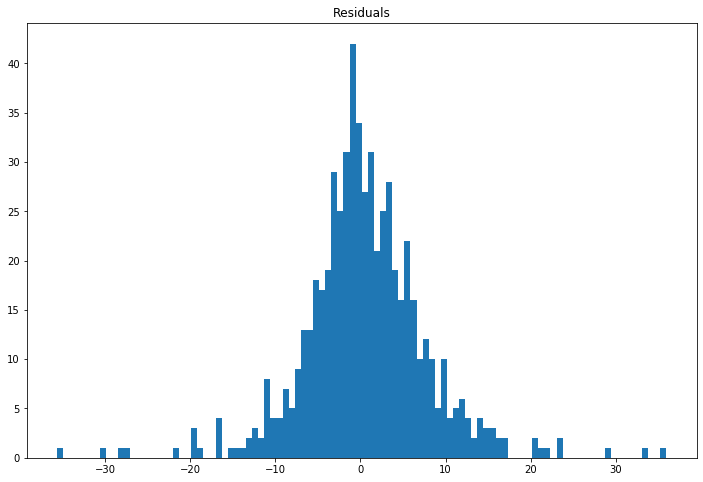

In [37]:
# мы хотим чтобы остатки были распределены по нормальному закону около нуля
# это является индикатором что ошибки случайны и не коррелируют
plt.figure(figsize=(12, 8))
plt.title('Residuals')
plt.hist(residuals, bins=100);
plt.show()

In [40]:
# бутстрепом набираем выборку коэффициентов линейной регрессии
beta_boots = []
B = 100
for i in tqdm(range(B)):
    bootstraped_data = bootstrap_timeseries(clf, X[0, :], residuals, len(data))
    X_boot, Y_boot = make_regression_from_timeseries(bootstraped_data, n)
    beta_boots.append(clf.fit(X_boot, Y_boot).coef_)
beta_boots = np.concatenate(beta_boots)

100%|██████████| 100/100 [00:09<00:00, 10.97it/s]


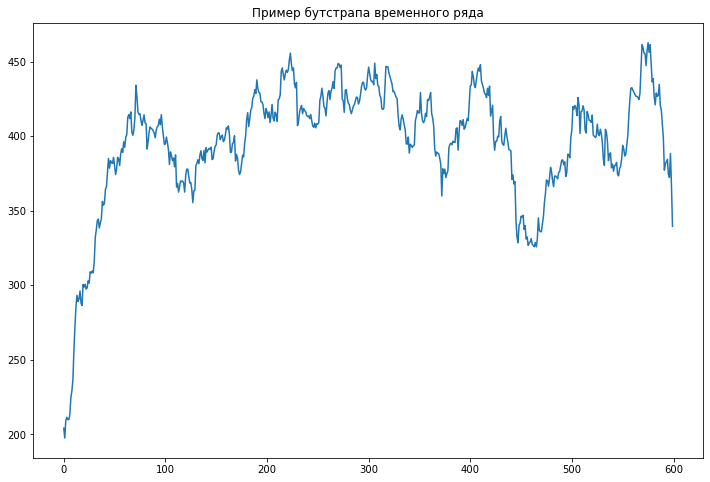

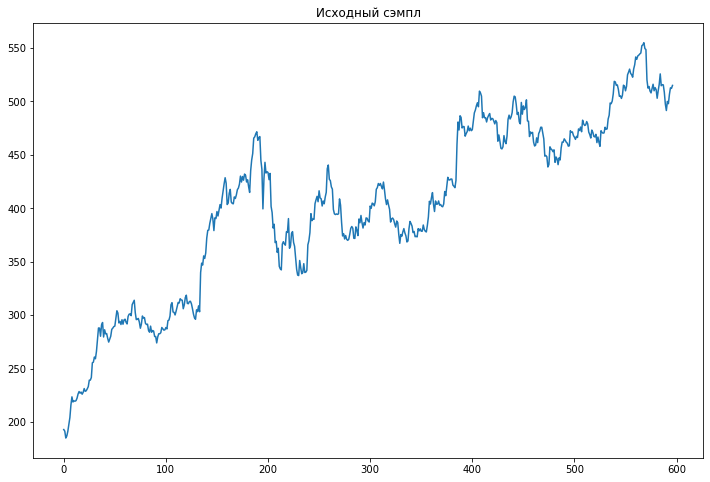

In [41]:
plt.figure(figsize=(12, 8))
plt.title('Пример бутстрапа временного ряда')
plt.plot(bootstraped_data + data_mean)
plt.show()

plt.figure(figsize=(12, 8))
plt.title('Исходный сэмпл')
plt.plot(Y + data_mean)
plt.show()

# 2. Bias

Смещение(bias) это разница между мат. ожиданием оценки статистики по сэмплу конечного размера и реальной величиной. 

$$\mathrm{bias}_F = \mathrm{bias}_F(\hat{\theta}, \theta) = E_F[\hat{\theta}] - \theta(F)$$

http://www.math.ntu.edu.tw/~hchen/teaching/LargeSample/notes/notebootstrap.pdf


$$\theta_0 = \theta(F_0) = \mu^3$$

$$\hat{\theta} = \theta(F_n) = \hat{X}^3$$


$$\mathrm{E} ~ \theta(F_n | F_0) = \mathrm{E}\left[ \mu + \frac{1}{n} \sum(x_i - \mu) \right]^3 = \mu^3 + \frac{1}{n} \mu \sigma^2 + \frac{\gamma}{n^2}$$

$$\mathrm{E} ~ \theta(F_n^* | F_n) = \hat{X}^3 + \frac{3}{n} \hat{X} \hat{\sigma}^2 + \frac{\hat{\gamma}}{n^2}$$

Так как распределение $F$ нам неизвестно, то оценивать мы будем по бутстрапному распределению, т.е.:

$$bias_{\hat{F}} = bias_{\hat{F}}(\hat{\theta}, \theta) = E_{\hat{F}}[\hat{\theta}^*] - \theta(\hat{F})$$

#### Bootstrap bias & jacknife bias

Для оценки смещения сравним обычный бутстреп и jacknife.

Для бутстрепа смещение считается следующим образом(следует из формулы :

$$\hat{bias}_B = \hat{\theta}^* - \hat{\theta}$$

Для jacknife смещение __определяется__ следующим образом:

$$\hat{bias}_{jack} = (n - 1) ( \hat{\theta}_{(\cdot)} - \hat{\theta})$$

# 3. Треугольное распределение

#### Плотность распределения:

![Треугольное распределение](https://wikimedia.org/api/rest_v1/media/math/render/svg/22e4e98ad8069ea39f61fe2f0be5b83b47f631bc)

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/45/Triangular_distribution_PMF.png/1024px-Triangular_distribution_PMF.png" alt="drawing" width="400"/>


#### Функция распределения:
![Функция распределения](https://wikimedia.org/api/rest_v1/media/math/render/svg/11b472d4e58e4df0814805aab0a2e752d6bdebf3)

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/e5/Triangular_distribution_CMF.png/1024px-Triangular_distribution_CMF.png" alt="drawing" width="400"/>

In [66]:
# CDF треугольного распределения с a = 0, b = 1, c = 2
def TrueTriangularDistrubition(x):
    if x < 0:
        return 0
    elif x < 1:
        return x**2 / 2
    elif x < 2:
        return 2*x - x**2 / 2 - 1
    else:
        return 1

In [69]:
# размер изначальной выборки
N = 300
# размер бутстрепной выборки
B = 5000

# сэмплируем из треугольного распределения
X = np.random.uniform(0, 1, size=N) + np.random.uniform(0, 1, size=N)

# бутстрапим
Xb = np.random.choice(X, (B, N), replace=True)
Xb.shape

(5000, 300)

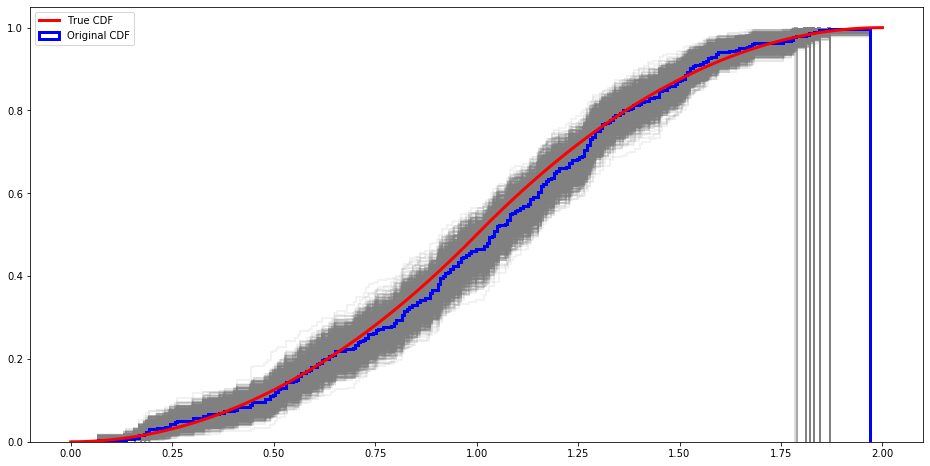

In [70]:
plt.figure(figsize = (16, 8))

# CDF для каждого бутстрепной выборки
for bootstrap_sample in Xb:
    plt.hist(bootstrap_sample, bins=N, density=True, histtype='step',
             cumulative=True, alpha = 0.1, color='grey', linewidth = 2)

# Истинное CDF
plt.plot(np.linspace(0, 2, 100), 
         list(map(TrueTriangularDistrubition, np.linspace(0, 2, 100))), 
         color = 'red', linewidth = 3, label='True CDF')    

# Эмпирическое CDF по изначальной выборке
plt.hist(X, bins=N, density=True, histtype='step',
         cumulative=True, label='Original CDF', color='blue', linewidth = 3)

plt.legend()
plt.show()

### Зависимость точности приближения распределений статистик бутстрепом

Один интересный практический вопрос это как быстро сходится бутстреп. Достаточно ли 10000 испытаний, а 1000, а 100?

В целом, чем больше тем лучше, но сейчас мы увидим, что даже для оценки CDF распределения верно что $B_k$ сходится к $B_{\infty}$(значение статистики при бесконечном количестве ресемплов) как $\frac{1}{\sqrt{n}}$.

100%|██████████| 999/999 [00:38<00:00, 26.05it/s] 


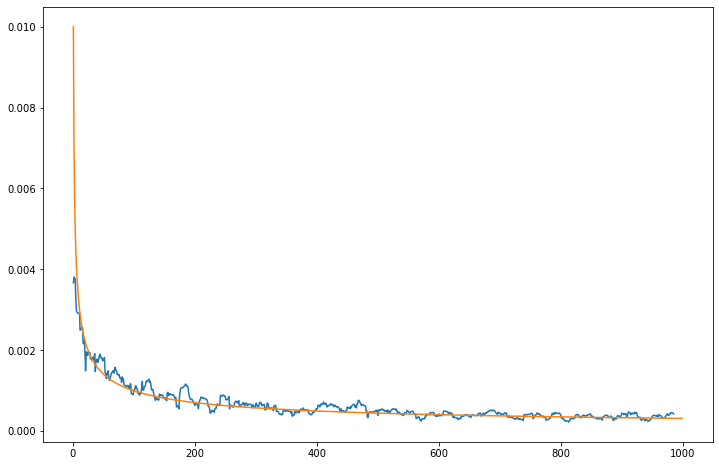

In [25]:
from tqdm import tqdm
# разбиение на бины
bins = np.linspace(0, 2, N)

# ground truth CDF
true_distr = np.array(list(map(TrueTriangularDistrubition, np.linspace(0, 2, N - 1))))

means = []

# диапазон количества испытаний для которых будем смотреть на зависимость
Bs = np.arange(1, 1000, 1)
for B in tqdm(Bs):
    # бутстрап выборки X B раз
    Xb = np.random.choice(X, (B, N), replace=True)
    cdfs = []
    for bootstrap_sample in Xb:
        # считаем разность CDF полученного бутстрапом и ground truth
        cdfs.append(
            true_distr - np.cumsum(np.histogram(bootstrap_sample, bins=bins)[0] / N)
        )
    # считаем среднее от разностей CDF
    means.append(np.array(cdfs).mean(axis=0))
    
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

# считаем бегущую дисперсию, чтобы получить более гладкий график
r = np.std(rolling_window(np.array(means).mean(axis=1), 15), -1)

plt.figure(figsize=(12, 8))
plt.plot(Bs[:len(r)], r)
plt.plot(Bs, 1e-2 / np.sqrt(Bs))

# 4. Интегрирование с помощью бутстрепа

Интегрирование функции $$f(x) = x \cos (71 x) + \frac{\sin (13 x^2)}{x}$$ на интервале $(0, 1)$.

/root/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


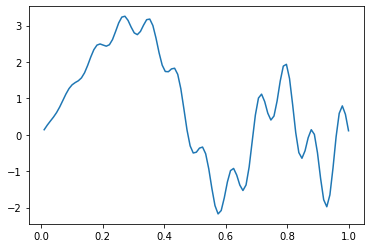

In [26]:
def f(x):
    return x * np.cos(71 * x) + np.sin(13 * x**2) / x


x = np.linspace(0, 1, 100)

plt.plot(x, f(x))

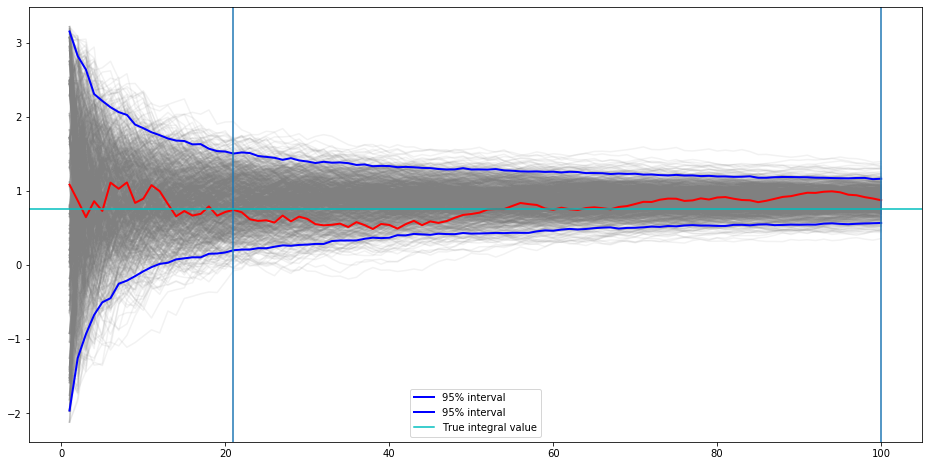

In [27]:
# data sample for integration
n = 100
x = f(np.random.random(n))

# bootstrap MC integration
reps = 1000
xb = np.random.choice(x, (n, reps), replace=True)
yb = 1 / np.arange(1, n+1)[:, None] * np.cumsum(xb, axis=0)
upper, lower = np.percentile(yb, [2.5, 97.5], axis=1)


plt.figure(figsize = (16, 8))
plt.plot(np.arange(1, n+1)[:, None], yb, c='grey', alpha=0.1)
plt.plot(np.arange(1, n+1), yb[:, 0], c='red', linewidth=2)
plt.plot(np.arange(1, n+1), upper, 'b', np.arange(1, n+1), lower, 'b', linewidth=2, label='95% interval');
plt.axvline(21, 0, 1)
plt.axvline(100, 0, 1)
plt.axhline(0.762816332183, c='c', label='True integral value')
plt.legend()
plt.show()

dfv